# Random forest predictions
This notebook ingests the positive and negative training vectors as well as positive and negative validation sets as generated by the notebook ``ExtractDifferenceVectorsHistoricalPhase4.ipynb``. Positive and training datasets are obtained up to the taregt year of phase 4. Positive validation sets are obtained for all subsequent years after the target year of phase 4. 

In [1]:
import pandas as pd
import os
import sys
import numpy as np
sys.path.insert(0, os.path.abspath('../..'))
from kcet import KcetParser
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import matplotlib.pyplot as plt
from numpy import sqrt
from numpy import argmax
import matplotlib
from sklearn.metrics import precision_score, recall_score


number of positive training links upto 2010: 132
number of negative training links upto 2010: 1146
number of positive validation links 1 years after 2010 : 21
number of negative validation links 1 years after 2010 : 1146
Total training vectors: 1278
Total training labels: 1278
Total test vectors: 1157
Total test labels: 1157
{'n_estimators': [100, 200, 300, 400, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, None], 'min_samples_split': [2, 3, 5, 7, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   6.1s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   7.4s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; tot

[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   6.1s
Best Threshold for auc=0.14867, G-Mean=0.861
[[1153   13]
 [ 104   74]]
0.8351648351648352 0.42696629213483145
Threshold for pr =0.49083, F-Score=0.565
precision=0.85, recall=0.42


number of positive training links upto 2010: 132
number of negative training links upto 2010: 1146
number of positive validation links 8 years after 2010 : 267
number of negative validation links 8 years after 2010 : 1146
Total training vectors: 1278
Total training labels: 1278
Total test vectors: 1400
Total test labels: 1400
{'n_estimators': [100, 200, 300, 400, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, None], 'min_samples_split': [2, 3, 5, 7, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf

/Users/ravanv/PycharmProjects/KCET/kcet_env/lib/python3.7/site-packages/ipykernel_launcher.py:118: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


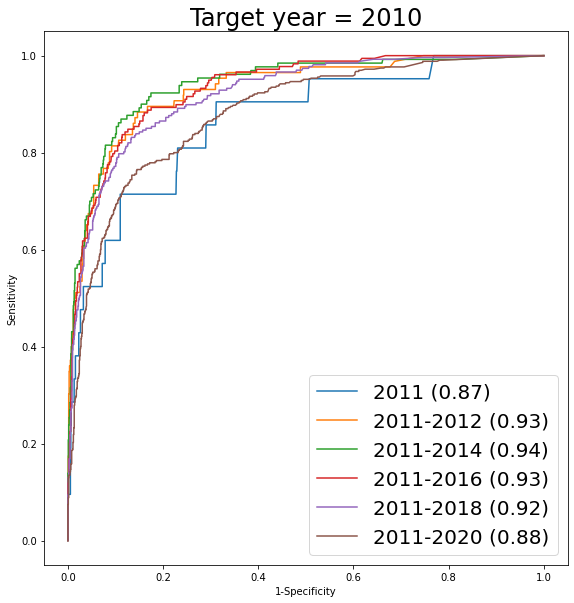

In [2]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
#ax2 = fig.add_subplot(122)
fig.tight_layout()
font = {'family' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)
target_year = 2010

for num_years_later in [1,2,4,6,8,10]:
    positive_validation_pickle_path = "positive-valid-vectors-{}-years-after-{}-phase4.pkl".format(num_years_later,target_year)
    negative_validation_pickle_path = "negative-valid-vectors-{}-years-after-{}-phase4.pkl".format(num_years_later,target_year)
    positive_train_pickle_path = "positive-train-vectors-{}.pkl".format(target_year)
    negative_train_pickle_path =  "negative-train-vectors-{}.pkl".format(target_year)
    diff_vectors_pos_validation = pd.read_pickle(positive_validation_pickle_path)
    diff_vectors_neg_validation = pd.read_pickle(negative_validation_pickle_path)
    diff_vectors_pos_training = pd.read_pickle(positive_train_pickle_path)
    diff_vectors_neg_training = pd.read_pickle(negative_train_pickle_path)
    print("number of positive training links upto {}: {}".format(target_year,diff_vectors_pos_training.shape[0]))
    print("number of negative training links upto {}: {}".format(target_year,diff_vectors_neg_training.shape[0]))
    print("number of positive validation links {} years after {} : {}".format(num_years_later, target_year, diff_vectors_pos_validation.shape[0]))
    print("number of negative validation links {} years after {} : {}".format(num_years_later, target_year, diff_vectors_neg_training.shape[0]))
    
    X_train = pd.concat([diff_vectors_pos_training,diff_vectors_neg_training])
    print("Total training vectors: %d" % len(X_train))
    
    label_1 = np.ones(diff_vectors_pos_training.shape[0])
    label_0 = np.zeros(diff_vectors_neg_training.shape[0])
    y_train = np.concatenate((label_1,label_0))
    print("Total training labels: %d" % len(y_train))
    
    X_test = pd.concat([diff_vectors_pos_validation,diff_vectors_neg_validation])
    print("Total test vectors: %d" % len(X_test))
    
    label_1 = np.ones(diff_vectors_pos_validation.shape[0])
    label_0 = np.zeros(diff_vectors_neg_validation.shape[0])
    y_test = np.concatenate((label_1,label_0))
    print("Total test labels: %d" % len(y_test))
    
    
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    #Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 3, 5, 7, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    print(random_grid)
    
    

    rf = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 1, cv = 10, verbose=2, random_state=10)

    rf_random.fit(X_train,y_train)

    best_model = rf_random.best_estimator_
    
    
    y_pred = best_model.predict(X_test)
    yproba = best_model.predict_proba(X_test)[::,1]
    
    fpr, tpr, thresholds_auc = roc_curve(y_test,  yproba)
    gmeans = sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix_gmeans = argmax(gmeans)
    print('Best Threshold for auc=%.5f, G-Mean=%.3f' % (thresholds_auc[ix_gmeans], gmeans[ix_gmeans]))
    
    
    print(metrics.confusion_matrix(y_test,y_pred))
    auc_roc = roc_auc_score(y_test, yproba)
    if num_years_later == 1:
        ax1.plot(fpr, tpr, label='2011 (%0.2f)' %(auc_roc))
        #ax1.scatter(fpr[ix_gmeans], tpr[ix_gmeans], marker='o', color='black', label='Best')

    else:
        ax1.plot(fpr, tpr, label='2011-%d (%0.2f)' %(num_years_later + target_year  ,auc_roc))
        #ax1.scatter(fpr[ix_gmeans], tpr[ix_gmeans], marker='o', color='black')
        
        
    precision, recall, thresholds_pr = precision_recall_curve(y_test, yproba)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    #print("precision", precision, 'recall', recall)
    diff_threshold = 0.01
    for i in range(len(fscore)):
        if abs(recall[i] - 0.5 * precision[i]) < diff_threshold:
            print(precision[i],recall[i])
            break
    # locate the index of the largest f score
    #ix_fscore = argmax(fscore)
    ix_fscore = i
    print('Threshold for pr =%.5f, F-Score=%.3f' % (thresholds_pr[ix_fscore], fscore[ix_fscore]))
    precision_best_threshold = precision_score(y_test, y_pred > thresholds_pr[ix_fscore])
    recall_best_threshold = recall_score(y_test, y_pred > thresholds_pr[ix_fscore])
    print('precision=%.2f, recall=%.2f\n\n' % (precision_best_threshold, recall_best_threshold))
    
    #ax2.plot(recall, precision, label='%d year(s) after %d, precision-recall (area = %0.2f)' % (num_years_later,target_year, auc_recall_precision))
    ax1.set_title('Target year = 2010')
    ax1.set_xlabel('1-Specificity')
    ax1.set_ylabel('Sensitivity')
    ax1.legend(loc="lower right")
    
fig.show()